In [1]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Figure 5

In [10]:
vocab_map = np.load("vocab/m_x_u_mt5_map.npy")
vocab_categories = np.load("vocab/mt5_categories.npy")
neighbors = pd.read_csv("mt5-xl/neighbors.tsv", sep="\t", quoting=csv.QUOTE_NONE, header=None)
neighbors.columns = ["score", "token_idx", "token", "neighbor_idx", "neighbor_token"]

neighbors = neighbors[neighbors['token_idx'].isin(vocab_map)]

neighbors['token_category'] = neighbors['token_idx'].apply(lambda x: vocab_categories[x])
neighbors['neighbor_category'] = neighbors['neighbor_idx'].apply(lambda x: vocab_categories[x])
neighbors['order'] = neighbors.groupby("token_idx").cumcount()
neighbors = neighbors[neighbors['order'] <= 50]

In [11]:
keep_category = dict()

for category in ['KATAKANA', 'HIRAGANA', 'CJK', 'LATIN', 'CYRILLIC']:
    category_df = neighbors[neighbors['token_category']==category].copy()
    g = category_df.groupby(["token_idx", "token", "neighbor_category"]).size().reset_index(name='size')
    top_ten = g.groupby("neighbor_category")['size'].mean().sort_values(ascending=False).index[:10].values
    keep_category[category] = top_ten

In [12]:
keep_category

{'KATAKANA': array(['LATIN', 'KATAKANA', 'CJK', 'S', 'CYRILLIC', 'CANADIAN', 'P',
        'HIRAGANA', 'M', 'THAI'], dtype=object),
 'HIRAGANA': array(['HIRAGANA', 'CJK', 'LATIN', 'S', 'BOPOMOFO', 'HANGUL', 'M', 'THAI',
        'CYRILLIC', 'KATAKANA'], dtype=object),
 'CJK': array(['CJK', 'LATIN', 'HIRAGANA', 'S', 'CYRILLIC', 'HANGUL', 'N', 'C',
        'KATAKANA', 'THAI'], dtype=object),
 'LATIN': array(['LATIN', 'CYRILLIC', 'S', 'CJK', 'N', 'M', 'MODIFIER', 'P',
        'GREEK', 'ARABIC'], dtype=object),
 'CYRILLIC': array(['CYRILLIC', 'LATIN', 'S', 'CJK', 'GREEK', 'N', 'ARABIC', 'M',
        'SYRIAC', 'P'], dtype=object)}

In [13]:
keep_category = ["KATAKANA", "HIRAGANA", "CJK","LATIN", "CYRILLIC"]

In [14]:
category_df = neighbors[neighbors['token_category'].isin(['KATAKANA', 'HIRAGANA', 'CJK', 'LATIN', 'CYRILLIC'])].copy()

In [15]:
g = category_df.groupby(["token_idx", "token", "token_category", "neighbor_category"]).size().reset_index(name='size')
g = g[g['neighbor_category'].isin(keep_category)]

In [16]:
g.head()

,token_idx,token,token_category,neighbor_category,size
2,0,<pad>,LATIN,CJK,5
3,0,<pad>,LATIN,CYRILLIC,3
8,0,<pad>,LATIN,LATIN,16
16,2,<unk>,LATIN,CJK,2
17,2,<unk>,LATIN,CYRILLIC,4


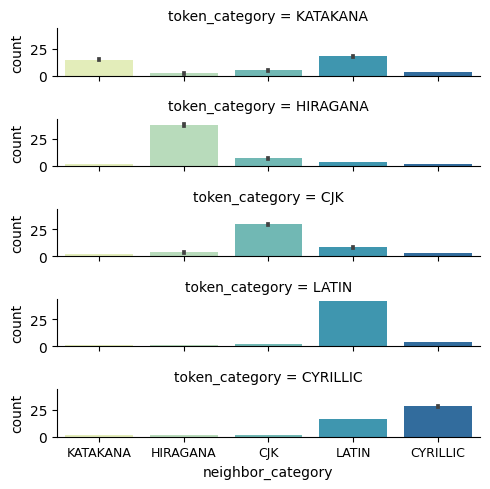

In [39]:
sns.set_palette("YlGnBu")
fig = sns.catplot(
    data=g, x="neighbor_category", y="size", row="token_category",
    kind="bar", height=1, aspect=5, order = keep_category,
    row_order = ['KATAKANA', 'HIRAGANA', 'CJK', 'LATIN', 'CYRILLIC'],
)
fig.tick_params(axis="x", labelrotation=0, labelsize=9)
fig.set_ylabels("count")
plt.tight_layout()
plt.savefig("./figures/figure5-neighbor_breakdown.png", dpi=400)

## Figure 9

In [18]:
vocab_map = np.load("vocab/frequency_mt5_map.npy")
vocab_categories = np.load("vocab/mt5_categories.npy")
neighbors = pd.read_csv("mt5-xl/neighbors.tsv", sep="\t", quoting=csv.QUOTE_NONE, header=None)
neighbors.columns = ["score", "token_idx", "token", "neighbor_idx", "neighbor_token"]

neighbors = neighbors[neighbors['token_idx'].isin(vocab_map)]

neighbors['token_cat'] = neighbors['token_idx'].apply(lambda x: vocab_categories[x])
neighbors['neighbor_cat'] = neighbors['neighbor_idx'].apply(lambda x: vocab_categories[x])
neighbors['order'] = neighbors.groupby("token_idx").cumcount()
neighbors = neighbors[neighbors['order'] <= 50]

In [19]:
lang = pd.read_csv("/share/magpie/datasets/mc4/merged_counts.tsv", sep="\t", quoting=csv.QUOTE_NONE)
df = lang.groupby(["TokenID", "Token"])['Count'].sum().reset_index(name='count')

vocab_categories = np.load("vocab/mt5_categories.npy")

vocab = np.load("vocab/mt5_vocab.npy", allow_pickle=True)

df['Category'] = df['TokenID'].apply(lambda x: vocab_categories[x])
df = df.sort_values("count").reset_index(drop=True)
# sanity check
# from collections import Counter
# Counter(np.ceil(10*(df.index+1) / len(df)))

df['frequency_bracket'] = np.ceil(10*(df.index+1) / len(df))
# frequency_map = df.groupby("frequency_bracket").sample(frac=0.01)['TokenID'].values
# np.save("vocab/frequency_mt5_map.npy", frequency_map)

In [20]:
df.head()

,TokenID,Token,count,Category,frequency_bracket
0,243611,ⳃ,1,COPTIC,1.0
1,248451,㰓,1,CJK,1.0
2,249935,䀻,1,CJK,1.0
3,247946,᲌,1,C,1.0
4,249908,㘤,1,CJK,1.0


In [21]:
neighbors = neighbors.merge(df, left_on='token_idx', right_on='TokenID', how='left')

In [22]:
neighbors['frequency_bracket'] = neighbors['frequency_bracket'].astype(int)

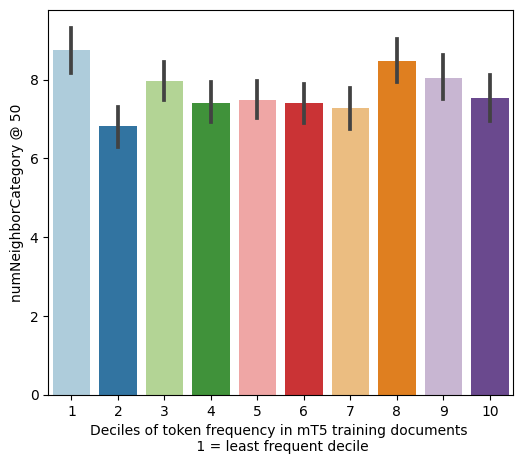

In [40]:
plt.figure(figsize=(6,5))
sns.set_palette("Paired")
x = neighbors.groupby(['token_idx', 'frequency_bracket'])['neighbor_cat'].nunique().reset_index(name='num_neighbor_cats')
ax = sns.barplot(data=x, x='frequency_bracket', y='num_neighbor_cats')
# ax.set_title("all tokens")
ax.set_ylabel("numNeighborCategory @ 50")
ax.set_xlabel("Deciles of token frequency in mT5 training documents \n 1 = least frequent decile")
plt.savefig("./figures/figure9-frequency_and_numNeighborCategory.png", bbox_inches='tight', dpi=400)